In [39]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
yellow_jan_df = pd.read_parquet('../model/yellow_tripdata_2020-01.parquet')

In [41]:
zones_lookup_df = pd.read_csv('./taxi_zone_lookup.csv')
zone_shp = gpd.read_file('./taxi_zones.shp')

In [42]:
zone_shp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [43]:
def clean_data(df):
    df['VendorID'] = df['VendorID'].astype(str)

    # Convert lpep_pickup_datetime and tpep_dropoff_datetime to pandas datetime.
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

    # drop every store_and_fwd_flag value different from 'N' or 'Y' or 'n' or 'y' or 'no' or 'yes' or 'ye' or 'ys'
    valid_flags = ['N', 'Y', 'n', 'y', 'no', 'yes', 'ye', 'ys']
    df = df[df['store_and_fwd_flag'].isin(valid_flags)]
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1,'n': 0,'y':1,'no': 0,'yes':1,'ye':1,'ys':1})
    
    
    try:

        # Make RatecodeID, PULocationID, DOLocationID, passenger_count, payment_type, trip_type as int type
        int_cols = ['store_and_fwd_flag','RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'payment_type', 'trip_type']
        for col in int_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1).astype(int)

    except:
        print("Skiped column")

    # Drop negative or zero values of trip_distance, fare_amount, total_amount
    df = df[(df['trip_distance'] > 0) & (df['fare_amount'] > 0) & (df['total_amount'] > 0) & (df['passenger_count'] > 0) & (df['tip_amount'] > 0)]

    # Drop negative values of congestion_surcharge, improvement_surcharge, tolls_amount, tip_amount, extra, mta_tax
    df = df[(df['congestion_surcharge'] > 0) & (df['improvement_surcharge'] > 0) & (df['tolls_amount'] > 0) &
            (df['tip_amount'] > 0) & (df['extra'] > 0) & (df['mta_tax'] > 0)]

    # Convert ehail_fee None to Nan

    try:
        df['ehail_fee'] = df['ehail_fee'].replace('None', np.nan).astype(float)
    except:
        print("Skiped column")

    # Drop duplicated rows
    df = df.drop_duplicates()
    
    # Drop rows with same pickup and dropoff time
    df = df[df['tpep_pickup_datetime'] != df['tpep_dropoff_datetime']]
    
    return df


def merge_taxi_with_zones(taxi_df, zones_df):
    """
    Merges a New York City taxi dataframe with a zones dataframe based on the pickup or dropoff location ID.
    :param taxi_df: New York City taxi dataframe with pickup and dropoff location IDs.
    :param zones_df: NYC taxi zone lookup table dataframe.
    :param loc_col: Column name for the pickup or dropoff location ID in the taxi dataframe.
    :return: Merged dataframe with the additional zone, borough, and service zone columns.
    """
    # Merge the taxi dataframe with the zones dataframe based on the location ID column
    merged_df = pd.merge(taxi_df, zones_df, left_on='PULocationID', right_on='LocationID')
    # Drop the duplicate location ID column
    merged_df = merged_df.drop(columns='LocationID')
    # Rename the remaining columns
    merged_df = merged_df.rename(columns={'Borough': 'PU_borough', 'Zone': 'PU_zone', 'service_zone': 'PU_service_zone'})
    
    merged_df = pd.merge(merged_df, zones_df, left_on='DOLocationID', right_on='LocationID')
    merged_df = merged_df.drop(columns='LocationID')
    merged_df = merged_df.rename(columns={'Borough': 'DO_borough', 'Zone': 'DO_zone', 'service_zone': 'DO_service_zone'})
    return merged_df

In [44]:
def plot_pickup_zones(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.scatter(df['pickup_longitude'], df['pickup_latitude'], s=0.1)
    ax1.set_title('Zonas de Recogida')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax2.scatter(df['dropoff_longitude'], df['dropoff_latitude'], s=0.1)
    ax2.set_title('Zonas de Llegada')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Latitud')

    plt.show()

In [45]:
zones_df = {
    'yellow_jan' : clean_data(merge_taxi_with_zones(yellow_jan_df, zones_lookup_df))
}

Skiped column
Skiped column


In [46]:
zones_df['yellow_jan']['origin'] = 'yellow_jan'
merged_df = zones_df['yellow_jan']

/var/folders/ll/k1r938ks4lq77qs662mx95sm0000gn/T/ipykernel_15540/3051484930.py:8: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  fig = sns.catplot(x='count', y='PU_zone', hue='origin', col='origin', col_wrap=2, data=pickups_by_zone, kind='bar', height=4, aspect=1.5, palette=colors, sharex=False, sharey=False)


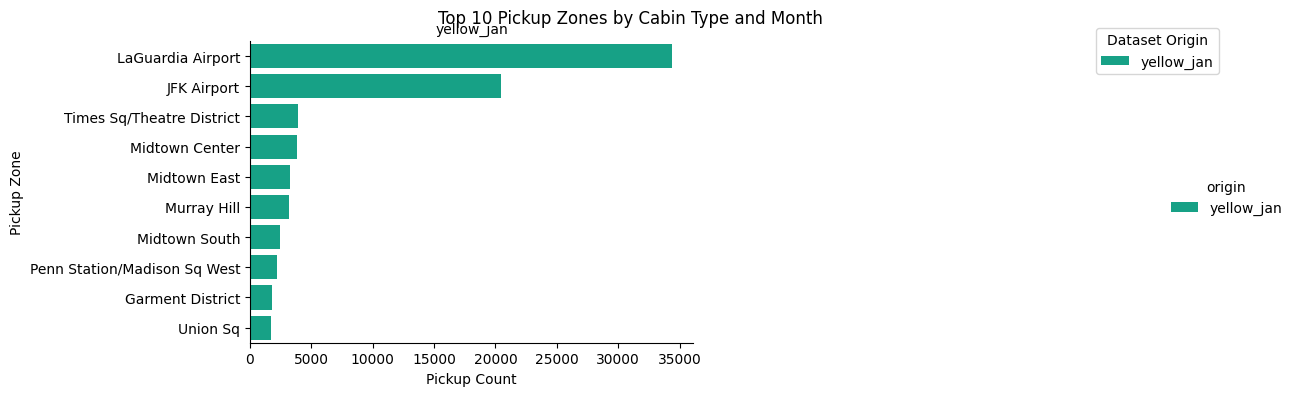

In [47]:
zones_cols = ['PU_borough', 'PU_zone', 'PU_service_zone']
pickups_by_zone = merged_df.groupby(['origin', *zones_cols]).size().reset_index(name='count')

pickups_by_zone = pickups_by_zone.sort_values(['origin', 'count'], ascending=[True, False]).groupby('origin').head(10)

colors = sns.color_palette(['#00b894','#55efc4','#fdcb6e', '#ffeaa7'])

fig = sns.catplot(x='count', y='PU_zone', hue='origin', col='origin', col_wrap=2, data=pickups_by_zone, kind='bar', height=4, aspect=1.5, palette=colors, sharex=False, sharey=False)
fig.figure.subplots_adjust(top=0.9)
fig.figure.suptitle('Top 10 Pickup Zones by Cabin Type and Month')
fig.set_axis_labels('Pickup Count', 'Pickup Zone')
fig.set_titles('{col_name}')

for ax in fig.axes.flat:
    ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.figure.legend(handles, labels, title='Dataset Origin', loc='upper right', bbox_to_anchor=(0.95, 0.95))

In [48]:
zones_shape = pd.merge(merged_df, zone_shp, left_on='PULocationID', right_on='LocationID')
zones_shape.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,DO_zone,DO_service_zone,origin,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,2020-01-01 00:44:31,2020-01-01 01:11:20,2,5.2,1,0,249,112,1,...,Greenpoint,Boro Zone,yellow_jan,249,0.036384,0.000072,West Village,249,Manhattan,"POLYGON ((983555.319 204876.901, 983469.158 20..."
1,1,2020-01-01 00:39:40,2020-01-01 01:03:26,2,13.7,1,0,262,134,1,...,Kew Gardens,Boro Zone,yellow_jan,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."
2,1,2020-01-01 00:46:26,2020-01-01 01:25:41,1,11.8,1,0,48,67,1,...,Dyker Heights,Boro Zone,yellow_jan,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
3,1,2020-01-01 00:59:30,2020-01-01 01:44:51,2,7.0,1,0,186,181,1,...,Park Slope,Boro Zone,yellow_jan,186,0.024696,0.000037,Penn Station/Madison Sq West,186,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21..."
4,1,2020-01-01 00:02:57,2020-01-01 00:35:52,2,17.2,2,0,132,68,1,...,East Chelsea,Yellow Zone,yellow_jan,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283..."


In [49]:
zones_shape = gpd.GeoDataFrame(zones_shape, geometry=zones_shape.geometry)

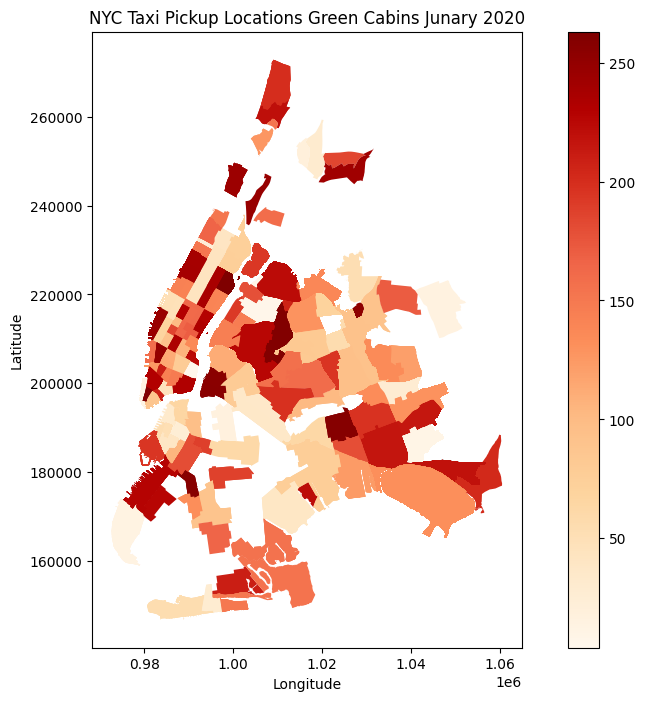

In [51]:
# Create a Figure object and an Axes object
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the data
zones_shape[zones_shape['origin'] == 'yellow_jan'].plot(column="PULocationID", cmap="OrRd", ax=ax)

# Add a legend and colorbar
ax.set_title("NYC Taxi Pickup Locations Green Cabins Junary 2020")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
cbar = fig.colorbar(ax.collections[0])

# Show the plot
plt.show()